In [1]:
import numpy as np
import torch
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.transforms import Lambda
import os, sys
import matplotlib.pyplot as plt
import pickle
from torchvision.models.resnet import resnet50, ResNet50_Weights

In [2]:
file_path = os.path.dirname(os.path.abspath('.'))
sys.path.append(file_path)

In [3]:
file_path

'C:\\Users\\negra\\mymlprojects\\cifar10'

In [4]:
from src.CIFAR10dataset import CIFAR10dataset
from src.SmallCNN import SmallCNN

## DEFINE IMAGE TRANSFORMS

In [18]:
cifar_mean = [0.4914,0.4822,0.4465]
cifar_stdev = [0.2470,0.2435,0.2616]

In [19]:
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize(cifar_mean,cifar_stdev)])
tgt_tf = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

## LOAD CIFAR10 DATASET

In [7]:
train_val_ds = CIFAR10dataset(root='../data',train=True,transform=tf,target_transform = tgt_tf)
test_ds = CIFAR10dataset(root='../data',train=False,transform=tf,target_transform=tgt_tf)

In [9]:
gen1 = torch.Generator().manual_seed(1)
train_frac = 0.9
val_frac = 1 - train_frac
train_ds, val_ds = torch.utils.data.random_split(train_val_ds,[train_frac,val_frac],generator=gen1)

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=64,shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [20]:
def show_image(im):
    stdev = torch.tensor(cifar_stdev)
    stdev = stdev.reshape((3,1,1))
    mean = torch.tensor(cifar_mean)
    mean = mean.reshape((3,1,1))
    im = im*stdev+mean
    im = torch.permute(im,(1,2,0))
    plt.imshow(im)
    plt.show()

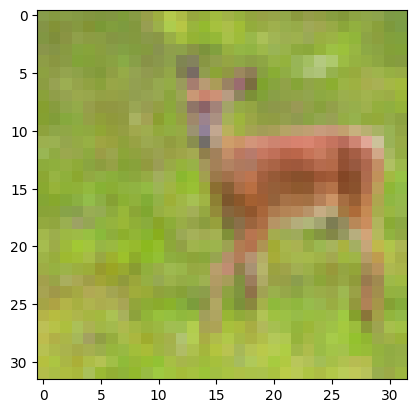

In [21]:
im1,label = next(iter(train_dl))
show_image(im1[0])

## DEFINE MODEL, OPTIMIZER, LOSS FUNCTION, DEVICE

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mo1 = SmallCNN().to(device)
opt1 = optim.SGD(mo1.parameters(),lr=0.005)

In [32]:
loss_fn = torch.nn.CrossEntropyLoss()

## DEFINE TRAINING LOOP

In [33]:
def train_model(model,train_data,val_data,optimizer,loss_fn,epochs=1):
    n_train_samples = len(train_data.dataset.indices)
    n_val_samples = len(val_data.dataset.indices)
    best_acc = 0
    for e in range(1,epochs+1):
        model.train()
        cum_train_loss = 0
        cum_val_loss = 0
        train_acc = 0
        val_acc = 0
        for i,(example,label) in enumerate(train_data):
            example = example.to(device)
            label = label.to(device)
            vals,lbl_classes = label.max(dim=1)
            pred = model(example)
            vals, prd_classes = pred.max(dim=1)
            loss = loss_fn(pred,label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            cum_train_loss += loss/n_train_samples
            train_acc += sum(lbl_classes == prd_classes)
            if i % 100 == 0:
                print(f'Cumulative train loss = {cum_train_loss}, Batch = {i}')
        model.eval()
        with torch.no_grad():
            for i,(example,label) in enumerate(val_data):
                example = example.to(device)
                label = label.to(device)
                vals,lbl_classes = label.max(dim=1)
                pred = model(example)
                vals,prd_classes = pred.max(dim=1)
                loss = loss_fn(pred,label)
                cum_val_loss += loss/n_val_samples
                val_acc += sum(lbl_classes == prd_classes)
                if i % 100 == 0:
                    print(f'Cumulative validation loss = {cum_val_loss}, Batch = {i}')
            train_acc = train_acc/n_train_samples
            val_acc = val_acc/n_val_samples
            info_str = f'Epoch {e} train/val loss: {cum_train_loss:.4f}/{cum_val_loss:.4f} \n train/val accuracy: {train_acc:.4f}/{val_acc:.4f}'
            print(info_str)
            print('\n')
            if val_acc > best_acc + 0.01:
                best_acc = val_acc
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict':optimizer.state_dict(),
                            'loss':cum_val_loss,
                            'acc':val_acc},
                           f'..\models\cifar_model_v1_it{e}.pt')
            
            
    

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
C:\Users\negra\AppData\Local\Temp\ipykernel_23604\3657586241.py:50: SyntaxWarning: invalid escape sequence '\m'
  f'..\models\cifar_model_v1_it{e}.pt')


## TRAIN MODEL

In [34]:
train_model(mo1,train_dl,val_dl,opt1,loss_fn,epochs=20)

Cumulative train loss = 5.2288523875176907e-05, Batch = 0
Cumulative train loss = 0.005016714334487915, Batch = 100
Cumulative train loss = 0.009655636735260487, Batch = 200
Cumulative train loss = 0.01410465594381094, Batch = 300
Cumulative train loss = 0.018401095643639565, Batch = 400
Cumulative train loss = 0.022577278316020966, Batch = 500
Cumulative train loss = 0.026620281860232353, Batch = 600
Cumulative train loss = 0.030592037364840508, Batch = 700
Cumulative validation loss = 0.000372387352399528, Batch = 0
Epoch 1 train/val loss: 0.0307/0.0296 
 train/val accuracy: 0.3171/0.3257


Cumulative train loss = 3.834317612927407e-05, Batch = 0
Cumulative train loss = 0.003901868360117078, Batch = 100
Cumulative train loss = 0.007683132775127888, Batch = 200
Cumulative train loss = 0.011374392546713352, Batch = 300
Cumulative train loss = 0.015043859370052814, Batch = 400
Cumulative train loss = 0.018628666177392006, Batch = 500
Cumulative train loss = 0.02218238264322281, Batch = 

## LOAD PRETRAINED RESNET50 NN AND TUNE TO CIFAR10 CLASSIFICATION TASK

In [ ]:
ref_mo = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)


In [ ]:
for p in ref_mo.parameters():
    p.requires_grad = False

In [ ]:
ref_mo.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=2048,out_features=512,bias=True),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=32,bias=True),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=10,bias=True)
)

In [ ]:
ref_mo = ref_mo.to(device)

In [ ]:
ref_opt = torch.optim.SGD(ref_mo.parameters(),lr=0.01)

In [ ]:
ref_loss = torch.nn.CrossEntropyLoss()

## TRAIN RESNET50 OUTPUT LAYERS

In [ ]:
train_model(ref_mo,train_dl,val_dl,ref_opt,ref_loss,epochs=10)

## DEFINE EVALUATION LOOP

In [36]:
def eval_model(model,test_data,loss_fn):
    model.eval()
    cum_test_loss = 0
    test_acc = 0
    n_samples = len(test_data.dataset)
    with torch.no_grad():
        for i,(example,label) in enumerate(test_data):
            example = example.to(device)
            label = label.to(device)
            pred = model(example)
            loss = loss_fn(pred,label)
            cum_test_loss += loss
            vals,lbl_classes = label.max(dim=1)
            vals,pred_classes = pred.max(dim=1)
            test_acc += sum(pred_classes==lbl_classes)
        cum_test_loss = cum_test_loss/n_samples
        test_acc = test_acc/n_samples
        info_str = f'Test loss: {cum_test_loss:.4f} \n test accuracy: {test_acc:.4f}'
        print(info_str)
        
            
        

## EVALUATE MODEL PERFORMANCE ON TEST SET

In [38]:
eval_model(mo1,test_dl,loss_fn)

Test loss: 0.0177 
 test accuracy: 0.6141


## LOAD BEST MODEL AND SAVE WITH PICKLE

In [39]:
mo = SmallCNN()

In [43]:
checkpoint = torch.load("..\models\cifar_model_v1_it19.pt",weights_only=True)
mo.load_state_dict(checkpoint['model_state_dict'])

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\negra\AppData\Local\Temp\ipykernel_23604\3545717054.py:1: SyntaxWarning: invalid escape sequence '\m'
  checkpoint = torch.load("..\models\cifar_model_v1_it19.pt",weights_only=True)


<All keys matched successfully>

In [45]:
output_file = 'cifar_model_v1.bin'

In [46]:
with open(output_file,'wb') as f_out:
    pickle.dump((tf,mo),f_out)

## EVALUATE MODIFIED RESNET50 PERFORMANCE ON TEST SET

In [ ]:
eval_model(ref_mo,test_dl,ref_loss)